# BirdSet Fine-Tuning Tutorial

This notebook details how to fine-tune models on BirdSet data.

## Helper Functions

These functions are just helper functions for the code below. These can be ignored for now and looked up when they are used in the code.

### Custom Lightning Module

This snippet defines a custom LightningModule. It is needed as a wrapper for models loaded from Hugging Face if you want to train using the Lightning trainer, as it expects an instance of `Lightning.LightningModule` and models loaded from Hugging Face are not.

In [105]:
from transformers import ASTForAudioClassification, ConvNextForImageClassification
import lightning as l
import torch.nn as nn
from transformers import AdamW
    
class ConvNextClassifierLightningModule(l.LightningModule):
    def __init__(
            self,
            num_classes,
            num_epochs,
            ):
        super(ConvNextClassifierLightningModule, self).__init__()
        self.model = ConvNextForImageClassification.from_pretrained(
            "DBD-research-group/ConvNeXT-Base-BirdSet-XCM",
            # since HSN has a different number of labels we need to specify that
            num_labels=num_classes,
            ignore_mismatched_sizes=True
            )

        self.num_classes = num_classes
        self.num_epochs = num_epochs
    
    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        values = batch['input_values']
        labels = batch['labels']
        logits = self(values)

        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=5e-5)
    

### Event Limiting

In [106]:
import pandas as pd
import random
from tqdm import tqdm
from collections import Counter

def smart_sampling(dataset, label_name, class_limit, event_limit):
        def _unique_identifier(x, labelname):
            file = x["filepath"]
            label = x[labelname]
            return {"id": f"{file}-{label}"}

        class_limit = class_limit if class_limit else -float("inf")
        dataset = dataset.map(
            lambda x: _unique_identifier(x, label_name), desc="sampling: unique-identifier"
        )
        df = pd.DataFrame(dataset)
        path_label_count = df.groupby(["id", label_name], as_index=False).size()
        path_label_count = path_label_count.set_index("id")
        class_sizes = df.groupby(label_name).size()

        for label in tqdm(class_sizes.index, desc="sampling"):
            current = path_label_count[path_label_count[label_name] == label]
            total = current["size"].sum()
            most = current["size"].max()

            while total > class_limit or most != event_limit:
                largest_count = current["size"].value_counts()[current["size"].max()]
                n_largest = current.nlargest(largest_count + 1, "size")
                to_del = n_largest["size"].max() - n_largest["size"].min()

                idxs = n_largest[n_largest["size"] == n_largest["size"].max()].index
                if (
                    total - (to_del * largest_count) < class_limit
                    or most == event_limit
                    or most == 1
                ):
                    break
                for idx in idxs:
                    current.at[idx, "size"] = current.at[idx, "size"] - to_del
                    path_label_count.at[idx, "size"] = (
                        path_label_count.at[idx, "size"] - to_del
                    )

                total = current["size"].sum()
                most = current["size"].max()

        event_counts = Counter(dataset["id"])

        all_file_indices = {label: [] for label in event_counts.keys()}
        for idx, label in enumerate(dataset["id"]):
            all_file_indices[label].append(idx)

        limited_indices = []
        for file, indices in all_file_indices.items():
            limit = path_label_count.loc[file]["size"]
            limited_indices.extend(random.sample(indices, limit))

        dataset = dataset.remove_columns("id")
        return dataset.select(limited_indices)

### One-Hot Encoding

In [107]:
import torch

def classes_one_hot(batch, num_classes):
        """
        Converts class labels to one-hot encoding.

        This method takes a batch of data and converts the class labels to one-hot encoding.
        The one-hot encoding is a binary matrix representation of the class labels.

        Args:
            batch (dict): A batch of data. The batch should be a dictionary where the keys are the field names and the values are the field data.

        Returns:
            dict: The batch with the "labels" field converted to one-hot encoding. The keys are the field names and the values are the field data.
        """
        label_list = [y for y in batch["labels"]]
        class_one_hot_matrix = torch.zeros(
            (len(label_list), num_classes), dtype=torch.float
        )

        for class_idx, idx in enumerate(label_list):
            class_one_hot_matrix[class_idx, idx] = 1

        class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
        return {"labels": class_one_hot_matrix}

### Custom Datamodule

When using a lightning trainer you can either pass a Datamodule or the Dataloaders needed for the planed task. Typically a Datamodule would load the data, preprocess it and apply transforms. In this case the datamodule will only hold the data and provide Dataloaders. The other steps are done separately so as to not abstract each step too much.  
For a more typical implementation of Datamodules you should look into the `BirdSetDataModule` in `birdset/datamodules/birdset_datamodule.py`.

In [108]:
import lightning as L
from torch.utils.data import DataLoader

class CustomDatamodule(L.LightningDataModule):
    def __init__(self, dataset, batch_size):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size

    def setup(self, stage):
        pass 

    def train_dataloader(self):
        return DataLoader(dataset=self.dataset["train"], batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(dataset=self.dataset["valid"], batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(dataset=self.dataset["test"], batch_size=self.batch_size)

### Basic Transforms Wrapper

This class will help in handling the application of transforms on the data as well as converting the waveforms to spectrogramms. Transforms are stored in a list and then applied in the list order when a call to this class is made.

In [240]:
from dataclasses import dataclass
from torchaudio.transforms import Spectrogram, MelScale
from birdset.datamodule.components.resize import Resizer
from birdset.datamodule.components.augmentations import PowerToDB
import numpy as np
import torch_audiomentations
import torchvision.transforms


@dataclass
class ProcessingConfig:
    spectrogram_conversion: Spectrogram | None = Spectrogram(
            n_fft=1024,
            hop_length=320,
            power=2.0,
    )
    resizer: Resizer | None = Resizer(
            db_scale=True,
    ),
    melscale_conversion: MelScale | None = MelScale(
            n_mels=128,
            sample_rate=32000,
            n_stft=513, # n_fft//2+1
    ),
    dbscale_conversion: PowerToDB | None = PowerToDB(),
    normalize_spectrogram: bool = True,
    mean: float = -4.268,
    std: float = -4.569,

class BasicTransformsWrapper():
    def __init__(self,
                 wav_transforms,
                 spec_transforms,
                 decoding,
                 feature_extractor,
                 nocall_sampler,
                 processing_config = ProcessingConfig):
        self.wav_transforms = torch_audiomentations.Compose(
            transforms=wav_transforms,
            output_type="object_dict")
        self.spec_transforms = torchvision.transforms.Compose(
            transforms=spec_transforms
        )
        self.processing = processing_config
        self.nocall_sampler = nocall_sampler
        self.decoding = decoding
        self.feature_extractor = feature_extractor

    def __call__(self, batch, **kwds):

        batch = self.decoding(batch)

        waveform_batch = self._get_waveform_batch(batch)

        attention_mask = waveform_batch["attention_mask"]
        input_values = waveform_batch["input_values"]
        input_values = input_values.unsqueeze(1)
        labels = torch.tensor(batch["labels"])

        input_values, labels = self._waveform_augmentation(input_values, labels)

        print(input_values)


        if self.nocall_sampler:
            #input_values, labels = self.nocall_sampler(input_values, labels)
            pass

        if self.processing.spectrogram_conversion is not None:
            spectrograms = self.processing.spectrogram_conversion(input_values)

            if self.spec_transforms:
                spectrograms = self.spec_transforms(spectrograms)

            if self.processing.melscale_conversion:
                spectrograms = self.processing.melscale_conversion(spectrograms)

            if self.processing.dbscale_conversion:
                spectrograms = self.processing.dbscale_conversion(spectrograms)

            if self.processing.resizer:
                spectrograms = self.processing.resizer.resize_spectrogram_batch(spectrograms)
                
            if self.processing.normalize_spectrogram:
                spectrograms = (spectrograms - self.processing.mean) / self.processing.std
            
            input_values = spectrograms

        labels = torch.tensor(labels, dtype=torch.float16)

        print(input_values, labels)
        return {"input_values": input_values, "labels": labels}

    def _get_waveform_batch(self, batch):
        waveform_batch = [audio["array"] for audio in batch["audio"]]
        
        # extract/pad/truncate
        # max_length determains the difference with input waveforms as factor 5 (embedding)
        max_length = int(int(self.feature_extractor.sampling_rate) * int(self.decoding.max_len))
        waveform_batch = self.feature_extractor(
            waveform_batch,
            padding='max_length',
            max_length=max_length, 
            truncation=True,
            return_attention_mask=True
        )
        
        return waveform_batch

    def _waveform_augmentation(self, input_values, labels):
        labels = labels.unsqueeze(1).unsqueeze(1)
        output_dict = self.wav_transforms(
            samples=input_values, 
            sample_rate=self.feature_extractor.sampling_rate,
            targets=labels
        )
        labels = output_dict.targets.squeeze(1).squeeze(1)
        
        return input_values, labels

## Loading Data

There are two ways to use BirdSet datasets:

1. using BirdSets inbuild datamodules which manage the loading, preparing and transformation/augmentation of data
2. loading, preparing and transforming/augmenting the data manually

Both of these options are shown in this section.

### Using BirdSet Datamodules

This section shows how to load a dataset with BirdSets datamodules. These modules handle everythig for us and have a great amount of customizability. For more information about what the parameters of the various configs do, a look into the `birdset-pipeline_tutorial` notebook is advised. The configuration of datamodules is explained there.

Please note that `PretrainDataModule` should be used for the `XCL` and `XCM` datasets as they only have `train` splits.

In [7]:
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from birdset.configs.datamodule_configs import DatasetConfig, LoadersConfig
from birdset.datamodule.components.transforms import BirdSetTransformsWrapper
from birdset.datamodule.components import XCEventMapping

dataset_config = DatasetConfig(
        data_dir='../../data_birdset/HSN',
        hf_path='DBD-research-group/BirdSet',
        hf_name='HSN',
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        eventlimit=5,
        sampling_rate=32000,
        seed=2
    )
loaders_config = LoadersConfig()
transforms_config = BirdSetTransformsWrapper()
mapper_config = XCEventMapping()

datamodule = BirdSetDataModule(
    dataset = dataset_config,
    loaders=loaders_config,
    transforms=transforms_config,
    mapper=mapper_config,
)

The code above only configures the datamodule. To actully use it we need to also prepare the data (which also downloads it) and setup the dataloaders.

In [8]:
datamodule.prepare_data()
datamodule.setup(stage="fit")

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for DBD-research-group/BirdSet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DBD-research-group/BirdSet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


sampling: unique-identifier:   0%|          | 0/38170 [00:00<?, ? examples/s]

sampling: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


One-hot-encoding train labels. (num_proc=3):   0%|          | 0/17940 [00:00<?, ? examples/s]

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for DBD-research-group/BirdSet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DBD-research-group/BirdSet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for DBD-research-group/BirdSet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DBD-research-group/BirdSet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory

One-hot-encoding test_5s labels. (num_proc=3):   0%|          | 0/12000 [00:00<?, ? examples/s]

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for DBD-research-group/BirdSet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DBD-research-group/BirdSet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for DBD-research-group/BirdSet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DBD-research-group/BirdSet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory

Saving the dataset (0/1 shards):   0%|          | 0/14352 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3588 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

### Loading Data Manually

If you want to implement your own data pipeline you can also load the datasets through Hugging Face. This section will detail that aproach.  
Some amount of BirdSet Code will still be used here so as to not fill up this notebook with helper functions. If you want to, you can look up how those specific methods are coded and copy that.

In [205]:
from datasets import load_dataset

dataset = load_dataset(
    path="DBD-research-group/BirdSet",
    name="HSN",
    cache_dir="../../data_birdset/HSN",
    num_proc=4
    )

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for DBD-research-group/BirdSet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DBD-research-group/BirdSet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [206]:
print(dataset)
print(dataset["train"][0]["audio"])
print(dataset["train"][0]["detected_events"])

DatasetDict({
    train: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 5460
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 10296
    })
    test_5s: Dataset({
        features: [

#### Preprocessing the Data

You may heave seen that the `audio` column doesn't actually contain any audio data. The loaded dataset as it is, only contains the filepaths of the respective audiosamples. As shown above those files may also contain multiple birdcall events per file which is why it is not encouraged to directly load the whole audio into the sample (it may also just be too big). For BirdSet we typically specify some kind of eventlimit per file and per class and extract and map those events to singular samples in the dataset.

**Please Note:** Only the `train` split needs to be processed this way. Both the `test_5s` and `test` splits do not need to be processed like that.

In [207]:
from datasets import Audio
from birdset.datamodule.components.event_mapping import XCEventMapping

dataset["train"] = dataset["train"].cast_column(
    column="audio",
    feature=Audio(
        sampling_rate=32_000,
        mono=True,
        decode=False,
    ),
)

mapper = XCEventMapping()
dataset["train"] = dataset["train"].map(
    mapper,
    remove_columns=["audio"],
    batched=True,
    batch_size=300,
    num_proc=3,
    desc="Train event mapping"
)

dataset["train"] = dataset["train"].remove_columns("audio")

print(dataset)
print(dataset["train"][0]["filepath"])
print(dataset["train"][0]["detected_events"])

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 38170
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 10296
    })
    test_5s: Dataset({
        features: ['audio',

Now every event in the train split has been extracted into it's own sample. If you want to, you can limit these to some amount of events per class or per file.

In [208]:
dataset["train"] = smart_sampling(
    dataset=dataset["train"],
    label_name="ebird_code",
    class_limit=500,
    event_limit=5
)

print(dataset)

sampling: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 17940
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 10296
    })
    test_5s: Dataset({
        features: ['audio',

The last step of this part is to remove unnecessary columns or even whole splits. For BirdSet we use the `test_5s` split for multilabel testing. It contains 5 second long soundscape samples that may contain multiple birds per sample.  
To use it you need to remove the `test` split and rename the `test_5s` split to `test`.

Additionaly the dataset contains multiple columns that are not used and as such can be removed to make it more lightweight.

In [209]:
from datasets import DatasetDict

dataset = DatasetDict({"train": dataset["train"], "test": dataset["test_5s"]})
dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 17940
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 12000
    })
})

In [210]:
dataset = dataset.rename_column("ebird_code_multilabel", "labels")
dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'labels', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 17940
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'labels', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 12000
    })
})

In [211]:
columns_to_keep = {"filepath", "labels", "detected_events", "start_time", "end_time"}

removable_train_columns = [column for column in dataset["train"].column_names if column not in columns_to_keep]
removable_test_columns = [column for column in dataset["test"].column_names if column not in columns_to_keep]

print(removable_test_columns,"\n", removable_train_columns)

['audio', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'] 
 ['low_freq', 'high_freq', 'ebird_code', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel']


In [212]:
dataset["train"] = dataset["train"].remove_columns(removable_train_columns)
dataset["test"] = dataset["test"].remove_columns(removable_test_columns)

In [213]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 17940
    })
    test: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 12000
    })
})


In [214]:
dataset = dataset.map(
                    lambda batch: classes_one_hot(batch, num_classes=21),
                    batched=True,
                    batch_size=300,
                    load_from_cache_file=True,
                    num_proc=4,
                    desc=f"One-hot-encoding labels."
                )

One-hot-encoding labels. (num_proc=4):   0%|          | 0/17940 [00:00<?, ? examples/s]

/tmp/ipykernel_1340802/375418494.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
/tmp/ipykernel_1340802/375418494.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
/tmp/ipykernel_1340802/375418494.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
/tmp/ipykernel_1340802/375418494.py:24: UserWarni

#### Splitting the Data

The train split should be split into train and validation splits.

In [215]:
from datasets import DatasetDict

splits = dataset["train"].train_test_split(test_size=0.2)

dataset = DatasetDict({"train": splits["train"], "valid": splits["test"], "test": dataset["test"]})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 14352
    })
    valid: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 3588
    })
    test: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 12000
    })
})


#### Applying Transforms

As the datasets can get very big very quickly we suggest applying transforms on-the-fly. That means that transforms are only applied to a batch if it is requested (e.g. by a trainer). With huggingface datasets that is possible through the `set_transform` method. For this you will need a wrapper class that will be able to handle multiple transforms on the data. Here only a very basic one is implemented but like before you can look up a more sophisticated one in the BirdSet code (`BirdSetTransformsWrapper` in `birdset/datamodule/components/transforms.py`).

##### Decoding & Extracting

As previously mentioned the loaded dataset currently only contains filepaths but to apply transforms or use the data otherwise actual audio data is needed. As the name implies BirdSets `EventDecoding` class takes an event and pulls the associated audio data out of the respective file.

In [216]:
from birdset.datamodule.components.event_decoding import EventDecoding
from birdset.datamodule.components.feature_extraction import DefaultFeatureExtractor

decoder = EventDecoding(
    min_len=1,
    max_len=5,
    sampling_rate=32000,
    extension_time=8,
    extracted_interval=5
)

feature_extractor = DefaultFeatureExtractor(
    feature_size=1,
    sampling_rate=32000,
    padding_value=0.0,
    return_attention_mask=False
)

##### Nocall Sampling

Nocall Sampling uses other soundfiles to introduce samples which don't have any birdcalls in them as such samples are not included by default. To use Nocall Sampling you need to download background noise. BirdSet provides such functionality under `resources/utils/download_background_noise.py`. You will also need this background noise to use `AddBackgroundNoise` in the Waveform Transforms section.

In [217]:
from birdset.datamodule.components.augmentations import NoCallMixer

nocall = NoCallMixer(
    directory="../../data_birdset/dcase18",
    p=0.075,
    sampling_rate=32000,
    length=5
)

##### Waveform Transforms

In [218]:
wav_transforms = []

In [219]:
from birdset.datamodule.components.augmentations import MultilabelMix

multilabel_mix = MultilabelMix(
    p=0.7,
    min_snr_in_db=3.0,
    max_snr_in_db=30.0,
    mix_target="union"
)

wav_transforms.append(multilabel_mix)

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = MultilabelMix(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


In [220]:
from birdset.datamodule.components.augmentations import AddBackgroundNoise

background_noise = AddBackgroundNoise(
    p=0.5,
    min_snr_in_db=3,
    max_snr_in_db=30,
    sample_rate=32000,
    target_rate=32000,
    background_paths="../../data_birdset/background_noise"
)

wav_transforms.append(background_noise)

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = AddBackgroundNoise(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


In [221]:
from torch_audiomentations import AddColoredNoise

colored_noise = AddColoredNoise(
    p=0.2,
    max_f_decay=2,
    min_f_decay=-2,
    max_snr_in_db=30,
    min_snr_in_db=3
)

wav_transforms.append(colored_noise)

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = AddColoredNoise(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


In [222]:
from torch_audiomentations import Gain

gain = Gain(
    p=0.2,
    min_gain_in_db=-18,
    max_gain_in_db=6
)

wav_transforms.append(gain)

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = Gain(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


##### Spectrogramm Processing

In [223]:
from torchaudio.transforms import Spectrogram

spectrogramm_conversion = Spectrogram(
    n_fft=1024,
    hop_length=320,
    power=2.0
)

In [224]:
from torchaudio.transforms import MelScale

melscale_conversion = MelScale(
    n_mels=128,
    sample_rate=32000,
    n_stft=513
)

In [225]:
from birdset.datamodule.components.augmentations import PowerToDB

dbscale_conversion = PowerToDB()

In [226]:
from birdset.datamodule.components.resize import Resizer

resizer = Resizer(
    db_scale=True,
    target_height=None,
    target_width=None
)

In [227]:
processing_config = ProcessingConfig(
    spectrogram_conversion=spectrogramm_conversion,
    resizer=resizer,
    melscale_conversion=melscale_conversion,
    dbscale_conversion=dbscale_conversion,
    normalize_spectrogram=True,
    mean=-4.268,
    std=4.569
)

##### Spectrogram Transformation

In [228]:
spec_transforms = []

In [229]:
from torchvision.transforms import RandomApply
from torchaudio.transforms import FrequencyMasking

frequency_masking = RandomApply(
    p=0.5,
    transforms=[
        FrequencyMasking(
            freq_mask_param=100,
            iid_masks=True
        )
    ]
)

spec_transforms.append(frequency_masking)

In [230]:
from torchvision.transforms import RandomApply
from torchaudio.transforms import TimeMasking

time_masking = RandomApply(
    p=0.5,
    transforms=[
        FrequencyMasking(
            freq_mask_param=100,
            iid_masks=True
        )
    ]
)

spec_transforms.append(time_masking)

##### On The Fly Transforming

As mentioned we want to apply the transforms on a batch only as it is getting processed. To achieve that behaviour we use the `set_transform` mathod of huggingface datatets. The `test` split doesn't get transformed.

In [263]:
import torch

torch.manual_seed(2)

In [264]:
transforms = BasicTransformsWrapper(
    wav_transforms=wav_transforms,
    spec_transforms=spec_transforms,
    decoding=decoder,
    feature_extractor=feature_extractor,
    processing_config=processing_config,
    nocall_sampler=nocall
)

dataset["train"].set_transform(transforms, output_all_columns=False)
dataset["valid"].set_transform(transforms, output_all_columns=False)

In [268]:
from birdset.datamodule.components.transforms import PreprocessingConfig, BirdSetTransformsWrapper

transforms = BirdSetTransformsWrapper(
    task="multilabel",
    sampling_rate=32000,
    model_type="vision",
    spectrogram_augmentations={
        "frequency_masking": RandomApply(
            p=0.5,
            transforms=[
                FrequencyMasking(
                    freq_mask_param=100,
                    iid_masks=True
                )
            ]
        ),
        "time_masking": RandomApply(
            p=0.5,
            transforms=[
                FrequencyMasking(
                    freq_mask_param=100,
                    iid_masks=True
                )
            ]
        )
    },
    waveform_augmentations={
        "multilabel_mix": multilabel_mix,
        "add_background_noise":background_noise,
        "colored_noise":colored_noise,
        "gain":gain
    },
    decoding=EventDecoding(
        min_len=1,
        max_len=5,
        sampling_rate=32000,
        extension_time=8,
        extracted_interval=5
    ),
    feature_extractor=DefaultFeatureExtractor(
        feature_size=1,
        sampling_rate=32000,
        padding_value=0.0,
        return_attention_mask=False
    ),
    preprocessing=PreprocessingConfig(
        spectrogram_conversion=spectrogramm_conversion,
        resizer=resizer,
        melscale_conversion=melscale_conversion,
        dbscale_conversion=dbscale_conversion,
        normalize_spectrogram=True,
        mean=-4.268,
        std=4.569
    )
)

dataset["train"].set_transform(transforms, output_all_columns=False)
dataset["valid"].set_transform(transforms, output_all_columns=False)

#### Wrapping the Data in a Datamodule

In [269]:
datamodule = CustomDatamodule(dataset=dataset, batch_size=32)

In [270]:
datamodule.dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 14352
    })
    valid: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 3588
    })
    test: Dataset({
        features: ['filepath', 'start_time', 'end_time', 'labels', 'detected_events'],
        num_rows: 12000
    })
})

tensor([[[ 7.7831e-04,  7.5904e-04,  9.3682e-05,  ..., -1.6677e-03,
          -2.0916e-03, -1.1860e-03]],

        [[-2.2459e-03, -8.0915e-03, -6.8377e-03,  ..., -2.1656e-02,
          -2.7907e-02, -4.5017e-02]],

        [[-9.3343e-03, -1.2713e-02, -1.0178e-02,  ...,  1.4774e-02,
           2.2366e-03, -1.8701e-02]],

        ...,

        [[-4.0424e-03, -4.4840e-03, -2.4923e-04,  ..., -2.6152e-04,
           1.8321e-03,  7.8912e-03]],

        [[-1.4710e-03, -1.1355e-03, -1.0081e-03,  ..., -6.9573e-03,
          -1.1668e-02, -1.3759e-02]],

        [[-6.4687e-03, -7.0525e-03, -7.3837e-03,  ...,  2.7271e-03,
           1.8556e-03, -7.6477e-04]]])
tensor([[[[-7.2700, -7.2700, -7.2700,  ..., -7.2700, -7.2700, -7.2700],
          [-7.2700, -7.2700, -7.2700,  ..., -7.2700, -7.2700, -7.2700],
          [-7.0528, -7.1755, -7.2700,  ..., -6.8332, -7.2700, -7.2700],
          ...,
          [-7.2700, -7.2700, -7.2700,  ..., -7.2700, -7.2700, -7.2700],
          [-7.2700, -7.2700, -7.2700,  ..

/tmp/ipykernel_1340802/2932576419.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float16)


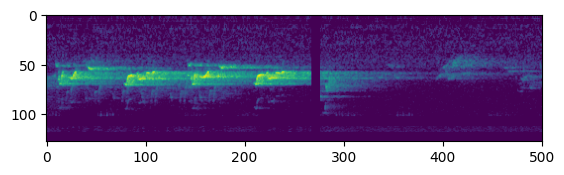

In [267]:
import matplotlib.pyplot as plt

dl = datamodule.train_dataloader()
sample = next(iter(dl))["input_values"][0]

plt.imshow(sample.squeeze().numpy())

/home/rantjuschin/BirdSet/birdset/datamodule/components/transforms.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float16)


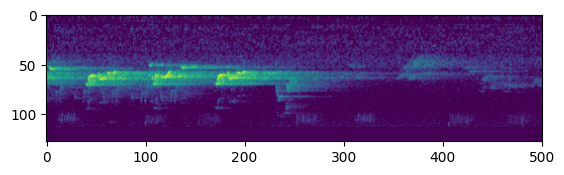

In [271]:
import matplotlib.pyplot as plt

dl = datamodule.train_dataloader()
sample = next(iter(dl))["input_values"][0]

plt.imshow(sample.squeeze().numpy())

## Setting up a Model

### Using BirdSets Pretrained Models with BirdSet

Here a model pretrained on the `XCL` dataset is loaded. Since it was trained on `XCL` and we want to use it on `HSN` we need to fine-tune it.

In [4]:
from birdset.modules.models.convnext import ConvNextClassifier
from birdset.modules.multilabel_module import MultilabelModule
from birdset.configs import NetworkConfig, LRSchedulerConfig, MultilabelMetricsConfig, LoggingParamsConfig

network = NetworkConfig(
    model=ConvNextClassifier(
        checkpoint="DBD-research-group/ConvNeXT-Base-BirdSet-XCM",
        num_classes=datamodule.num_classes,
        num_channels=1,
    ),
    model_name="convnext",
    model_type="vision"
)

model = MultilabelModule(
    network=network,
    num_epochs=5,
    len_trainset=datamodule.len_trainset,
    task=datamodule.task,
    batch_size=datamodule.train_batch_size
)

model

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for DBD-research-group/BirdSet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/DBD-research-group/BirdSet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at DBD-research-group/ConvNeXT-Base-BirdSet-XCL and

MultilabelModule(
  (loss): BCEWithLogitsLoss()
  (model): ConvNextClassifier(
    (model): ConvNextForImageClassification(
      (convnext): ConvNextModel(
        (embeddings): ConvNextEmbeddings(
          (patch_embeddings): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
          (layernorm): ConvNextLayerNorm()
        )
        (encoder): ConvNextEncoder(
          (stages): ModuleList(
            (0): ConvNextStage(
              (downsampling_layer): Identity()
              (layers): Sequential(
                (0): ConvNextLayer(
                  (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
                  (layernorm): ConvNextLayerNorm()
                  (pwconv1): Linear(in_features=128, out_features=512, bias=True)
                  (act): GELUActivation()
                  (pwconv2): Linear(in_features=512, out_features=128, bias=True)
                  (drop_path): Identity()
                )
                (1): Con

### Loading Models through Hugging Face

Loading a model through Hugging Face and then training it using a Lightning trainer is a bit more work as the trainer expects a `LightningModule`. This means that we need to wrap the model in such a module.

In [9]:
# ASTLightningModule is a custom class defined in the "Helper" section
# HSN contains 21 classes +1 for nocall
model = ConvNextClassifierLightningModule(22, num_epochs=5)
model

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at DBD-research-group/ConvNeXT-Base-BirdSet-XCM and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([411]) in the checkpoint and torch.Size([22]) in the model instantiated
- classifier.weight: found shape torch.Size([411, 1024]) in the checkpoint and torch.Size([22, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextClassifierLightningModule(
  (model): ConvNextForImageClassification(
    (convnext): ConvNextModel(
      (embeddings): ConvNextEmbeddings(
        (patch_embeddings): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
        (layernorm): ConvNextLayerNorm()
      )
      (encoder): ConvNextEncoder(
        (stages): ModuleList(
          (0): ConvNextStage(
            (downsampling_layer): Identity()
            (layers): Sequential(
              (0): ConvNextLayer(
                (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
                (layernorm): ConvNextLayerNorm()
                (pwconv1): Linear(in_features=128, out_features=512, bias=True)
                (act): GELUActivation()
                (pwconv2): Linear(in_features=512, out_features=128, bias=True)
                (drop_path): Identity()
              )
              (1): ConvNextLayer(
                (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1

## Starting Fine-Tuning with a Lightning Trainer

In [10]:
import lightning as L

trainer = L.Trainer(
    min_epochs=1,
    max_epochs=model.num_epochs,
    gradient_clip_val=0.5,
    precision=16,
    accumulate_grad_batches=1,
)

/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 10.57 GiB of which 11.06 MiB is free. Process 1074382 has 9.54 GiB memory in use. Process 1214932 has 712.00 MiB memory in use. Including non-PyTorch memory, this process has 326.00 MiB memory in use. Of the allocated memory 168.53 MiB is allocated by PyTorch, and 3.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [19]:
trainer.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/rantjuschin/miniconda3/envs/birdset/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/home/rantjuschin/BirdSet/birdset/datamodule/components/transforms.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float16)


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 10.57 GiB of which 19.06 MiB is free. Process 388427 has 232.00 MiB memory in use. Process 388495 has 258.00 MiB memory in use. Process 3792592 has 258.00 MiB memory in use. Including non-PyTorch memory, this process has 9.82 GiB memory in use. Of the allocated memory 9.61 GiB is allocated by PyTorch, and 9.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)